In [70]:
import tensorflow as tf
#from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, BatchNormalization, GaussianNoise
#from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from tensorflow.keras.optimizers import SGD
#from google.colab.patches import cv2_imshow

from skimage import data, io, filters

#from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
from os import listdir
from os.path import isfile, join
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2

Initial version of loading DataSet - from MyOwn Google Drive - switched to markdown not to run purposelessly

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/")
!ls
%cd MyDrive

# 0. Loading image

-1

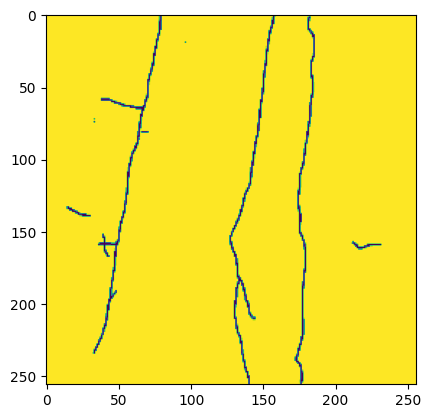

In [71]:
# Load an image of a random ROI for defected cell
img = cv2.imread("FV-Cells\Policristal\Full_Defected\\1130_ROI.bmp")
# Display original image
plt.imshow(img)
cv2.waitKey(0)
# Resize
img_size = 256
img = cv2.resize(img, (img_size, img_size), interpolation= cv2.INTER_LINEAR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img0 = img
plt.imshow(img)
cv2.waitKey(0)

### Adding gaussian blurring as a pre-processing step

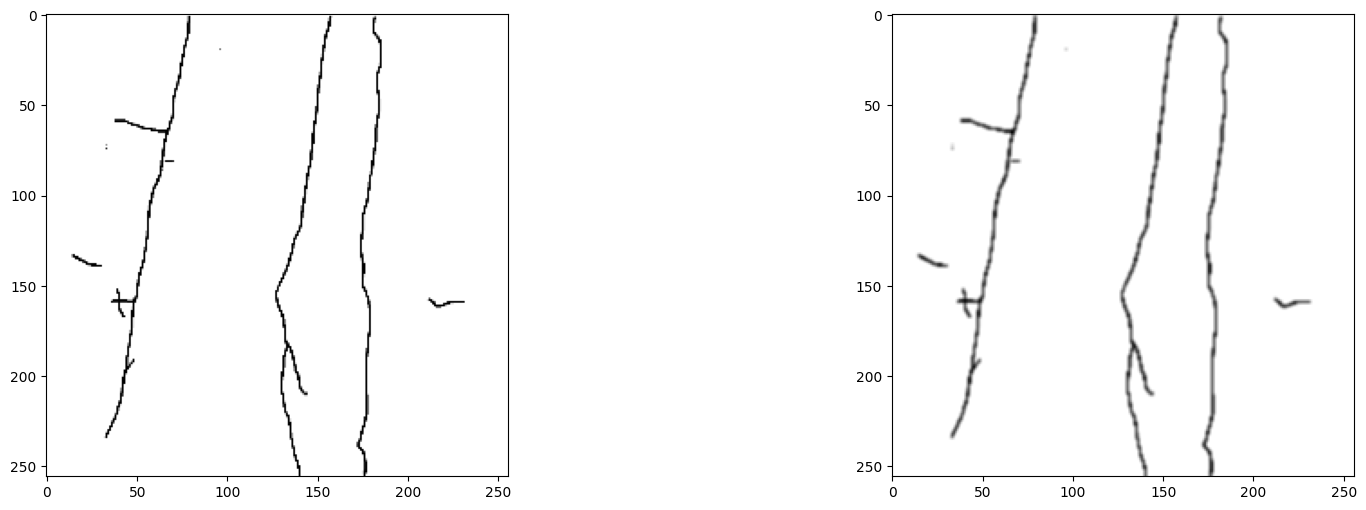

In [72]:
# Gaussian blurring
blur = cv2.GaussianBlur(img,(3,3),0)
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.imshow(img, 'gray')
plt.subplot(122)
plt.imshow(blur, 'gray')

# 1. Edge detection

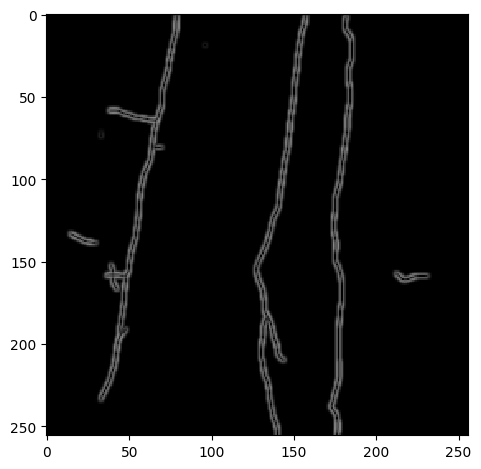

In [73]:
edges = filters.sobel(blur)
io.imshow(edges)
io.show()

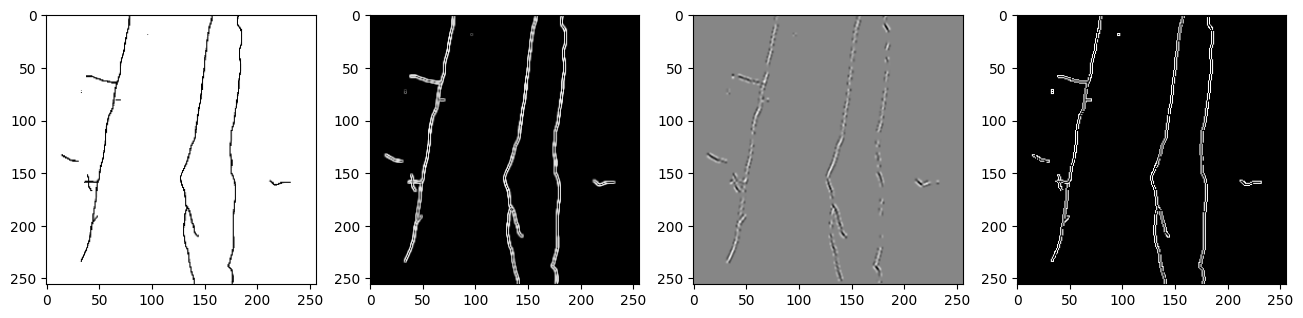

In [74]:
# Sobel Edge Detection
edges1 = filters.sobel(img)
edges2 = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Canny Edge Detection
edges3 = cv2.Canny(image=img, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Various Edge Detection Images
plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow(img0, 'gray')
plt.subplot(142)
plt.imshow(edges1, 'gray')
plt.subplot(143)
plt.imshow(edges2, 'gray')
plt.subplot(144)
plt.imshow(edges3, 'gray')
plt.show()

cv2.destroyAllWindows()

In [75]:
# After comparison of methods, the most promising seems to be Sobel filter from cv2 package:
img = edges1

# 2. Morphological operations

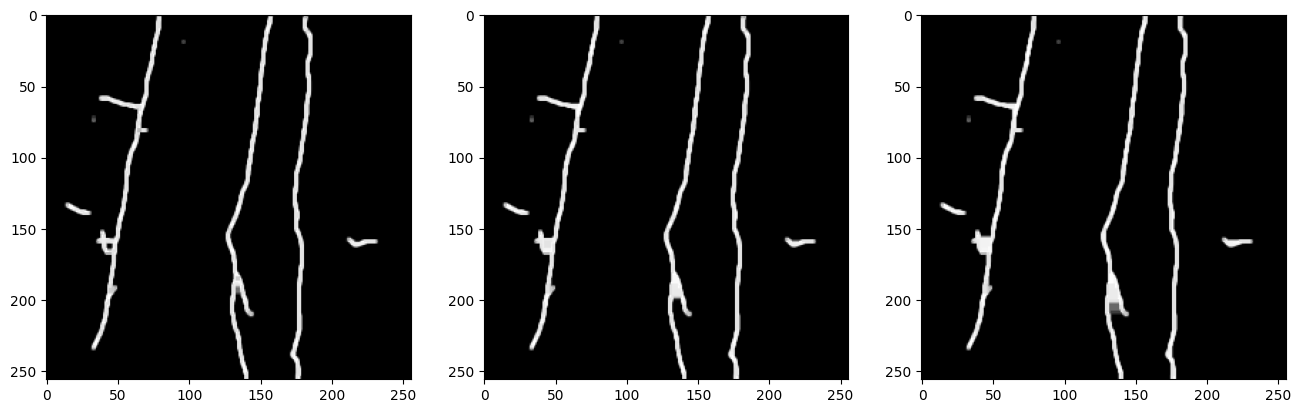

In [76]:
kernelSizes = [(3, 3), (5, 5), (7, 7)]
# Closing
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSizes[0])
closing1 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel1)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSizes[1])
closing2 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel2)
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSizes[2])
closing3 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel3)
# Visualize
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow(closing1, 'gray')
plt.subplot(132)
plt.imshow(closing2, 'gray')
plt.subplot(133)
plt.imshow(closing3, 'gray')
plt.show()
# So at the end we decide to use closing1:
img = closing1

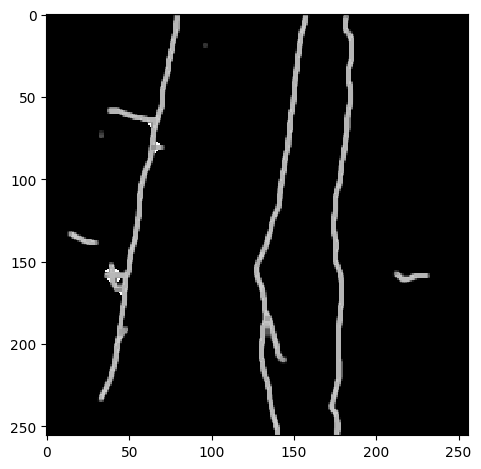

In [82]:
# Bridging
def connected4(img, i, j):
    l = [img[i-1][j], img[i][j+1], img[i+1][j], img[i][j-1]]
    
    if(sum(l)>1):
        return True
    else:
        return False

def bridging(img):
    aux = np.array(img)
    
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            
            if(img[i][j]==0):
                if(connected4(img, i, j)):
                    aux[i][j] = 1
            
    return aux
bridged = bridging(img)
io.imshow(bridged)
io.show()
img = bridged

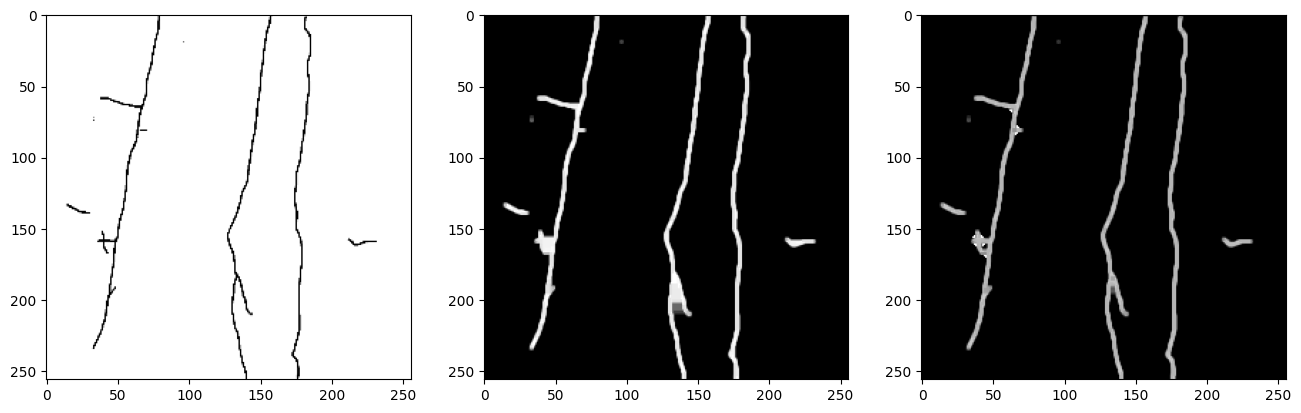

In [83]:
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow(img0, 'gray')
plt.subplot(132)
plt.imshow(closing3, 'gray')
plt.subplot(133)
plt.imshow(bridged, 'gray')
plt.show()

# 3. Labeling of detected components

c:\Users\01122464\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


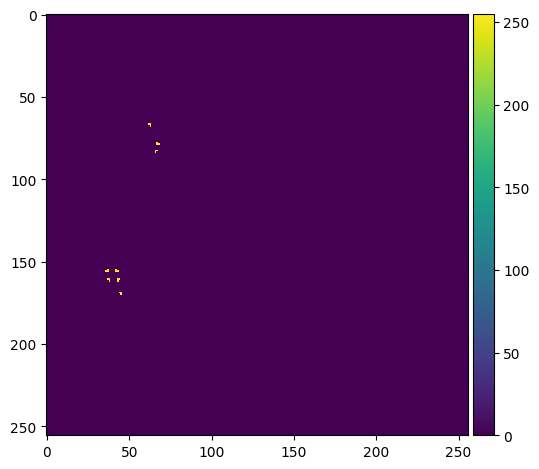

uint8


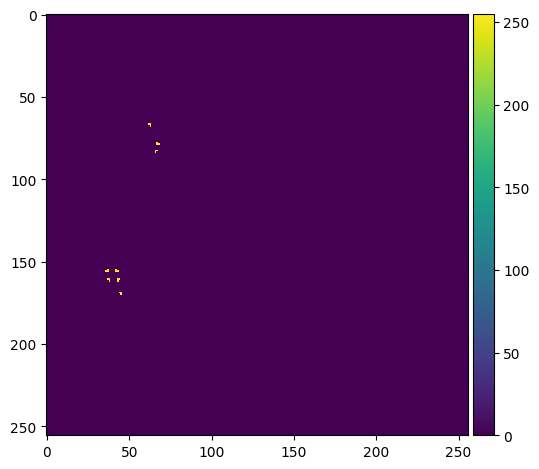

In [111]:
io.imshow(img)
io.show()
print(img.dtype)
# First - conversion of image data format from float64 to uint8
#info = np.iinfo(img.dtype) # Get the information of the incoming image type
#img = img.astype(np.float64) / info.max # normalize the data to 0 - 1
#img = 255 * img # Now scale by 255
#img = img.astype(np.uint8)
#cv2.imshow("Window", img)

img_n = cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
img = img_n.astype(np.uint8)
io.imshow(img)
io.show()
output = cv2.connectedComponentsWithStats(img)
(numLabels, labels, stats, centroids) = output

# 4. Classification of detected objects

9
False
True
[INFO] keeping connected component '1'
True
[INFO] keeping connected component '2'
True
[INFO] keeping connected component '3'
True
[INFO] keeping connected component '4'
True
[INFO] keeping connected component '5'
True
[INFO] keeping connected component '6'
True
[INFO] keeping connected component '7'
True
[INFO] keeping connected component '8'


C:\Users\01122464\AppData\Local\Temp\ipykernel_1220\1187605315.py:11: RuntimeWarning: invalid value encountered in scalar divide
  keepLinear = x/y > 0.0005 and x/y < 2000


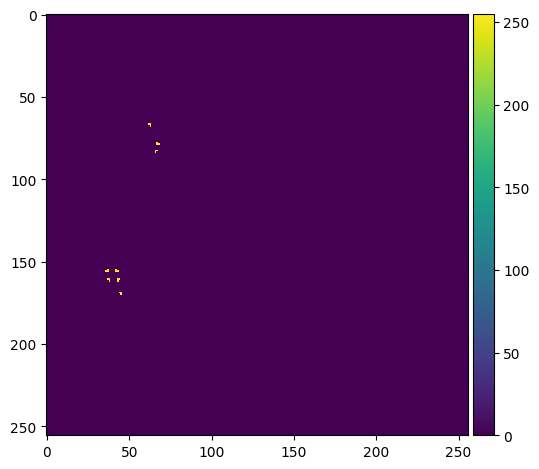

In [99]:
mask = np.zeros(img.shape, dtype="uint8")
# Extract statistics
for i in range(0, numLabels):
  # extract the connected component statistics for the current label
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  area = stats[i, cv2.CC_STAT_AREA]
  keepLinear = x/y > 0.0005 and x/y < 2000
  keepAxisRatio = h/w > 0.00005 and h/w < 2000
  keepArea = area > 1 and area < 50000
  print(keepLinear)
  # ensure the connected component we are examining passes all three tests
  if all((keepLinear, keepAxisRatio, keepArea)):
    # construct a mask for the current connected component and then take the bitwise OR with the mask
    print("[INFO] keeping connected component '{}'".format(i))
    componentMask = (labels == i).astype("uint8") * 255
    mask = cv2.bitwise_or(mask, componentMask)
io.imshow(mask)
io.show()